In [32]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot  as plt
import matplotlib
import numpy as np
import copy
from datetime import datetime  
from datetime import timedelta  
import os
os.environ["PROJ_LIB"] = "C:\\ProgramData\\Anaconda3\\Library\\share";
from mpl_toolkits.basemap import Basemap
from scipy import interpolate
from scipy import optimize
import random
import geopy.distance
import numpy as np
from scipy.interpolate import Akima1DInterpolator
from sklearn import datasets, linear_model

levels = [0, 1, 2, 3, 4, 5]
colors = ['black', 'green', 'brown', 'yellow', 'blue']
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
    
plt.rcParams["font.family"] = "Times New Roman"


SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [33]:
def parse_lat_lon(lat, lon):
    '''
        parse the latitude, longitude values 
        input is an array of the format 214N, 859W 
        (lat: 0 - 900 tenths of degrees, lon: 0 - 900 tenths of degrees,)
    '''   
    lat_ = []
    lon_ = []
    for x in lat:
        if 'N' in x:
            lat_.append(float(x.strip('N')))
        elif 'S' in x:
            lat_.append(-1*float(x.strip('S')))
    
    for x in lon:
        if 'E' in x:
            lon_.append(float(x.strip('E')))
        elif 'W' in x:
            lon_.append(-1*float(x.strip('W')))

    lat_ = np.array(lat_)/10.0
    lon_ = np.array(lon_)/10.0
    
    return lat_, lon_

def normalized_xy_Coords(lat, lon, m):
    nF = max(m.xmax, m.ymax)

    x, y = np.array(m(lon,lat,inverse=False))
    
    return [x/nF, y/nF]

def xy_Coords(lat, lon, m):

    x, y = np.array(m(lon,lat,inverse=False))
    
    return [x, y]

# return track position at arbitrary time 't' given the track sparse data points using B-spline interpolation
def storm_position(t_x, t_y, t_t, t):
    tck, u = interpolate.splprep([t_x, t_y, t_t], s=0.001) 
    u_fine = np.linspace(0,1,10000)
    ti_x, ti_y, ti_t = interpolate.splev(u_fine, tck)
    idx = (np.abs(ti_t - t)).argmin()
    return [ti_x[idx], ti_y[idx], ti_t[idx]]


def mean_ensemble(ensTracks, ens_wts):
    
    ens_wts = np.array(ens_wts) / np.sum(ens_wts)
    mens = np.zeros(ensTracks[0].shape)
    for tn in range(0,nens):
        mens = mens + ensTracks[tn]*ens_wts[tn]

    return mens


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# return track position at arbitrary time 't' given the track sparse data points using Akima interpolation
def storm_position_akima(t_x, t_y, t_t, t):

    akx = Akima1DInterpolator(t_t, t_x)
    aky = Akima1DInterpolator(t_t, t_y)
    return [akx(t), aky(t), t]

        

def storm_position_akima_extrapolate1pt(t_x, t_y, t_t, t):

    akx = Akima1DInterpolator(t_t, t_x)
    aky = Akima1DInterpolator(t_t, t_y)
    #extrapolate using the first order derivative at the end point      
    x_coord = akx(max(t_t)).flatten() + akx.derivative(1)(max(t_t))*(t - max(t_t))
    y_coord = aky(max(t_t)).flatten() + aky.derivative(1)(max(t_t))*(t - max(t_t))


    return np.array([x_coord, y_coord, t]).flatten()   

In [34]:
# Set some parameters
wdir = 'C:/Users/vravindr/Dropbox/my_workspace/tracking storms/'

data_dir = wdir + 'data/2018/'
ens_data_dir = data_dir + 'ensemble/'
bt_data_dir = data_dir + 'best_track/'

xfn = 'al012018'
basin ='Al'
Storms = ['ALBERTO'] # 2018: ALBERTO, BERYL, 2019: BARRY

ens_fn = ens_data_dir + 'a' + xfn + '.dat'
bt_fn = bt_data_dir + 'b' + xfn + '.dat'


nn_inp_fn = wdir + 'code/training_data/train_inputs_' + xfn + '.csv'
nn_label_fn = wdir + 'code/training_data/train_labels_' + xfn + '.csv'

# Storm to consider (all the forecasts of the storm are used)


ens_tn = ['AC00','AP01','AP02','AP03','AP04','AP05','AP06','AP07','AP08','AP09','AP10','AP11','AP12','AP13','AP14',
          'AP15','AP16','AP17','AP18','AP19','AP20']
ens_mean_tn = ['AEMN'] # ensemble mean track name
best_tn = ['BEST']

forecast_periods = [0, 6, 12, 18, 24, 30, 36, 42, 48] # forecast horizon is 24hrs, and time step is 6 hrs

nens = len(ens_tn)
ntst = len(forecast_periods) # number of time steps. 6hrs is the time step for the GEFS forecasts.

    
if(basin == 'Al'):
    # North Atlantic basin borders: lat: 0 deg to 50 deg, lon: 10W to 100W
    # Choose standard parallels: 16.67N and  33.33N, central lon: 45W, llcrnrlon=-100 , llcrnrlat=0, urcrnrlon=-10, urcrnrlat=50
    proj = Basemap(resolution='l',projection='eqdc',\
                lat_1=16.67,lat_2=33.33,lon_0=-45.0,
                llcrnrlon=-100 , llcrnrlat=0 , urcrnrlon=-10, urcrnrlat=50  )

nF = max(proj.xmax, proj.ymax) # normalizing factor of the coordinates (X, Y) used later
print(nF)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


9173846.41491117


In [35]:
cols_names = ['BASIN', 'CY', 'YYYYMMDDHH', 'TECHNUM/MIN', 'TECH', 'TAU', 'LatN/S', 'LonE/W', 'VMAX', 'MSLP', 'TY', 'RAD', 'WINDCODE', 
        'RAD1', 'RAD2', 'RAD3', 'RAD4', 'POUTER', 'ROUTER', 'RMW', 'GUSTS', 'EYE', 'SUBREGION', 'MAXSEAS', 'INITIALS', 'DIR', 
        'SPEED', 'STORMNAME', 'DEPTH', 'SEAS', 'SEASCODE', 'SEAS1', 'SEAS2', 'SEAS3', 'SEAS4', 'USERDEFINED1', 'userdata1',
        'USERDEFINED2', 'userdata2', 'USERDEFINED3', 'userdata3', 'USERDEFINED4', 'userdata4', 'USERDEFINED5', 'userdata5']

ens_data = pd.read_csv(ens_fn,names=cols_names, engine='python')
bt_data = pd.read_csv(bt_fn,names=cols_names, engine='python')

# parse and replace the latitude and longitude values
[lat, lon] = parse_lat_lon(ens_data['LatN/S'], ens_data['LonE/W'])
ens_data['LatN/S'] = lat
ens_data['LonE/W'] = lon

[lat, lon] = parse_lat_lon(bt_data['LatN/S'], bt_data['LonE/W'])
bt_data['LatN/S'] = lat
bt_data['LonE/W'] = lon

In [36]:
ens_data2 = copy.deepcopy(ens_data)

# populate the Storm name in rows which dont have it
storm_name = ens_data2.iloc[0]['STORMNAME'] # initialize storm name
for index, row in ens_data.iterrows():
    if(row['STORMNAME'] is None):
        ens_data2.iat[index, 27]= storm_name
    else:
        storm_name = row['STORMNAME'] 

ens_data2 = ens_data2.loc[ens_data2['TAU']>= min(forecast_periods)]
ens_data2 = ens_data2.loc[ens_data2['TAU']<= max(forecast_periods)]

# Add X, Y coordinates to the dataframes
[X, Y] = xy_Coords(np.array(ens_data2['LatN/S']),np.array(ens_data2['LonE/W']), proj)
ens_data2.insert(len(ens_data2.columns), "X", X) 
ens_data2.insert(len(ens_data2.columns), "Y", Y) 

[X, Y] = xy_Coords(np.array(bt_data['LatN/S']),np.array(bt_data['LonE/W']), proj)
bt_data.insert(len(bt_data.columns), "X", X) 
bt_data.insert(len(bt_data.columns), "Y", Y) 

In [37]:
ens_training_data = np.ndarray(shape=(1, nens*ntst), dtype=float)
mean_ens_data = np.ndarray(shape=(1, ntst), dtype=float)
bt_label_data = np.ndarray(shape=(1, ntst), dtype=float)

nD = 0 # number of data-sets collected

# loop over each storm
for st in Storms:    
    # extract the data containing the storm name
    ens_data3 = ens_data2[ens_data2['STORMNAME'].str.contains(st)]
    
    # find unique forecasts
    forecasts = ens_data3['YYYYMMDDHH'].unique()

    # regrid the (lat, lon) of the storms to (X,Y), and add the (X,Y) cols
    
    d1 = copy.deepcopy(ens_data3)    
    
    # loop over each forecast  
    for fc in forecasts:
        
        d2 = d1[d1['YYYYMMDDHH'] == fc]
        
        # extract set of [ensembles, mean ensemble, best-track] of this forecast, place them one below another
        ens_d = pd.DataFrame(columns=['YYYYMMDDHH', 'TECH', 'LatN/S', 'LonE/W'])
        bt_d = pd.DataFrame(columns=['YYYYMMDDHH', 'TECH', 'LatN/S', 'LonE/W'])   
        tracks = ens_tn + ens_mean_tn + best_tn
        for tn in tracks:
            d3 = copy.deepcopy(d2)
            d3 = d3[(d3['TECH'].str.contains(tn))]  
            d3 = d3.drop_duplicates(subset ="TAU") # drop rows with duplicate forecast period
            d3 = d3.sort_values(by='TAU', ascending=True) # make sure they are in ascending order
            ens_d = ens_d.append(d3, sort=False)
            # for best tracks there is no "forecast" date, rather the date in the column corresponds to the date of the track info
            if(tn =='BEST'):
                bd1 = copy.deepcopy(bt_data)
                fc_dt = datetime.strptime(str(fc), '%Y%m%d%H')
                array = []
                for fp in forecast_periods:
                    dt = fc_dt + timedelta(hours = fp)
                    array.append(dt.strftime('%Y%m%d%H'))
                bd1 = bd1.loc[bd1['YYYYMMDDHH'].isin(array)]
                bd1 = bd1.drop_duplicates(subset ="YYYYMMDDHH") # drop rows with duplicate dates
                bd1 = bd1.sort_values(by='YYYYMMDDHH', ascending=True) # make sure they are in ascending order
        
        if(len(ens_d) == (nens+1)*ntst and len(bd1)==ntst): # sometimes some enseble tracks may not have certain forecasts, 
            # and/or best track data may not be avialable. In that case the data is not added to the dataset.
            nD = nD + 1
            ed = ens_d[~ens_d['TECH'].str.contains(ens_mean_tn[0])]
            med = ens_d[ens_d['TECH'].str.contains(ens_mean_tn[0])]
            if(nD ==1): # very first dataset
                ens_training_data = ed.filter(['YYYYMMDDHH', 'TECH', 'LatN/S', 'LonE/W', 'X', 'Y']).to_numpy()
                mean_ens_data = med.filter(['YYYYMMDDHH', 'TECH', 'LatN/S', 'LonE/W', 'X', 'Y']).to_numpy()
                bt_label_data = bd1.filter(['YYYYMMDDHH', 'TECH', 'LatN/S', 'LonE/W', 'X', 'Y']).to_numpy()
            else:
                ens_training_data = np.vstack((ens_training_data, ed.filter(['YYYYMMDDHH', 'TECH', 'LatN/S', 'LonE/W', 'X', 'Y']).to_numpy()))
                mean_ens_data = np.vstack((mean_ens_data, med.filter(['YYYYMMDDHH', 'TECH', 'LatN/S', 'LonE/W', 'X', 'Y']).to_numpy()))
                bt_label_data = np.vstack((bt_label_data, bd1.filter(['YYYYMMDDHH', 'TECH', 'LatN/S', 'LonE/W', 'X', 'Y']).to_numpy()))
                  
            
            
print("Number of data sets collected: ", nD)
ens_training_data = ens_training_data.reshape(nD,nens*ntst,6)
mean_ens_data = mean_ens_data.reshape(nD,ntst,6)
bt_label_data = bt_label_data.reshape(nD,ntst,6)
            

Number of data sets collected:  12


## Iterative algorithm


1. At first opportunity, look at mean of the ensemble tracks (with prior supplied weight)
2. If present, reward the ensembles close to the observed point (radially decreasing outward) by a reward factor (function of the distance from the actual observed point)
3. Since storm was’nt observed, penalize all the ensemble tracks passing through that point and in neighbouring region (radially decreasing outwards)
4. Continue iteratively

In [38]:
def recalc_ens_weights_met2(known_storm_position, dud_obs, ens_wts, ensTracks, forecast_periods, senFPr):    
 
    x0 = ens_wts #current ensemble weights used as intiial value for optimization
    lbd = np.zeros((nens,1))
    ubd = np.ones((nens,1))
    bnds = np.hstack((lbd, ubd)) # ensemble weights must be positive
   
    optres = optimize.minimize(optfunc, x0, args=(ensTracks, forecast_periods, known_storm_position), method='L-BFGS-B', bounds = bnds, options={'maxiter': 10000})
    ens_wts = optres.x
    
    # penalize the ensemble tracks close to the dud observaiton points
    ens_wts = penalize_ensTcks_close_failedObs(ens_wts, ensTracks, dud_obs, forecast_periods, senFPr)

    return ens_wts

def penalize_ensTcks_close_failedObs(ens_wts, ensTracks, dud_obs, forecast_periods, senFPr):
    
    nens = ensTracks.shape[0]
    
    # iterate over all failed observations
    for fobs in dud_obs:
        fobs_t = fobs[2]
        # calculate distance between failed observation point and all other ensembles
        for k in range(0,nens):
            
            etck_x = list(ensTracks[k][:,2]) 
            etck_y = list(ensTracks[k][:,3])
            etck_t = forecast_periods
            etcki = storm_position_akima(etck_x, etck_y, etck_t, fobs_t)
    
            d_ens_obs = np.linalg.norm(np.array(etcki[0:2])-np.array(fobs[0:2]))
            #if(d_ens_obs < senFPr):
                #ens_wts[k] = ens_wts[k]*0.9 # penalize small distances
            ens_wts[k] = ens_wts[k]*np.exp(d_ens_obs*1e-6) # penalize small distances
            
    ens_wts = np.array(ens_wts) / np.sum(ens_wts) # normalize the ensemble weights
    return ens_wts
    
    
def optfunc(ens_wts, ensTracks, forecast_periods, known_storm_position):
    ''' Input function to the optimizer implemented in ensemble weight recalculation in algo2 '''

    # calculate total(over time) error between mean track and observed track from 1st storm observation until last storm observation
    mean_track = mean_ensemble(ensTracks, ens_wts)
    mtck = np.hstack((mean_track[:,2:4], np.array(forecast_periods).reshape(-1,1))) # mean track
    
    cost = calculate_error(known_storm_position, mtck)
    
    return cost

def calculate_track_slope(tck, time1, time2):
    ''' time2 > time1, time2 is the forecast time, 
        time1 is the time at which the forecast is made (previous observation time)
    '''
    pos1 = storm_position_akima(tck[:,0], tck[:,1], tck[:,2], time1)
    pos2 = storm_position_akima(tck[:,0], tck[:,1], tck[:,2], time2)
    dt = pos2[2] - pos1[2]
    vx = (pos2[0] - pos1[0])/dt
    vy = (pos2[1] - pos1[1])/dt
    return[vx, vy]

def calculate_kstp_slope(known_storm_position):
    lastIndx = known_storm_position.shape[0]-1
    pos1 = known_storm_position[lastIndx-1]
    pos2 = known_storm_position[lastIndx]
    dt = pos2[2] - pos1[2]
    vx = (pos2[0] - pos1[0])/dt
    vy = (pos2[1] - pos1[1])/dt
    return[vx, vy]
    
def calculate_error(known_storm_position, tck):
    ''' Calculate average of the error over between the known storm positions and the mean track.
    '''
    if(known_storm_position.size==0):
        return 0
    t_fine = known_storm_position[:,2]
    tck_fine = storm_position_akima(tck[:,0], tck[:,1], tck[:,2], t_fine)
    ksps = [known_storm_position[:,0], known_storm_position[:,1], known_storm_position[:,2]]
    error = np.sum(np.linalg.norm(np.array(ksps[0:2])-np.array(tck_fine[0:2])) )
    error = error/known_storm_position.size
    return error

def mid_point_regressed_line(Xsamples, Ysamples, time):
    '''
    '''
     # Create linear regression object
    regrX = linear_model.LinearRegression()
    regrY = linear_model.LinearRegression()

    # Train the model using the training sets
    regrX.fit(time.reshape(-1,1), Xsamples.reshape(-1,1))
    regrY.fit(time.reshape(-1,1), Ysamples.reshape(-1,1))

    # find known storm position at some point on and in the middle of the regressed line
    tmid = time[0] + 0.5 * (time[-1] - time[0])
    xmid = regrX.predict(tmid.reshape(-1,1)).flatten()
    ymid = regrY.predict(tmid.reshape(-1,1)).flatten()

    return [xmid[0], ymid[0], tmid]

def process_raw_storm_center_data(raw_storm_position, regr_seg_gap_hrs, regr_subseg_length_hrs, 
                                  segment_num, segment_raw_data_indices):
    ''' Process the raw storm center data and get estimated storm center positions. 
        The raw onservation would yeild noisy center acquisitions. The return vector has the estiamted storm center
        positions at the observation times when the storm center has been visible.
        Note that while the length of segment is vraiable, the length of the subsegment is always fixed.
    '''
    est_storm_position = [] # estimated from the raw storm positions
    segment_data = {} # contains raw storm info of releant segment
    min_dps_regrss = 1

    
    ''' Decide the segment indices, based on the gap length between the data points. 
        A gap of more than 'regr_seg_gap_hrs' wwill result in start of a new segment.
    '''
    raws =  raw_storm_position[~np.isnan(raw_storm_position).any(axis=1)] # drop nans
    
    last_valid_acq_time = raws[-1][2]    
    #print('regr_seg_gap_hrs: ', regr_seg_gap_hrs)
    if(raws.shape[0]>1):        
        seclast_valid_acq_time = raws[-2][2]

        if(last_valid_acq_time - seclast_valid_acq_time >= regr_seg_gap_hrs):
            segment_num = segment_num + 1 # start new segment
            
    if(segment_num == 0):
        segment_raw_data_indices[int(segment_num)] = [0, raws.shape[0]]
    else:
        segment_raw_data_indices[int(segment_num)] = [segment_raw_data_indices[int(segment_num)-1][1], raws.shape[0]]

    #print('---------------------------------------------')
    #print('segment_raw_data_indices')
    #print(segment_raw_data_indices)
    
    ''' Using the segment raw data indices, make estimated/ known storm interpolation points.
        Create subsegments when the segment is too long and find a regressed line fitting the subsegment.
        The midpoint of the regressed line serves as a interpolation data-point for the storm center.'''
    # iterate over each segment
    for seg_i in range(0,len(segment_raw_data_indices)):
        segment_data = raws[segment_raw_data_indices[seg_i][0]:segment_raw_data_indices[seg_i][1]]
        
        seg_num_data_pts = segment_data.shape[0]
        segment_data_start_time = segment_data[0,2]
        segment_data_end_time = segment_data[seg_num_data_pts-1,2]
        #print('segment_data')
        #print(segment_data) 
        
        if(seg_num_data_pts >= min_dps_regrss): # minimum of 1 data-points needed per segment.  
            # if only 1 data-point present, that point is returned as the estimated storm position
            
            segment_len_hrs = segment_data[seg_num_data_pts-1][2] - segment_data[0][2] 
            #print('segment_len_hrs: ', segment_len_hrs)
            
            # break into sub segments of length 'regr_subseg_length_hrs'. Note the use of ceil.
            num_sub_segments = int(np.ceil(segment_len_hrs/regr_subseg_length_hrs))
            #print('num_sub_segments: ', num_sub_segments)
            
            # iterate over all sub-segments except the last one. The last one is treated differently.
            sseg_i = 0

            # note that the last subsegment is treated differently
            for sseg_i in range(0,num_sub_segments-1):
                #subseg_data = np.where((segment_data[:,2]>= sseg_i*segment_data_start_time and segment_data[:,2]< (sseg_i+1)*segment_data_start_time))
                subseg_data = segment_data[ segment_data[:,2]>= segment_data_start_time + sseg_i*regr_subseg_length_hrs]
                subseg_data = subseg_data[ subseg_data[:,2]<= segment_data_start_time + (sseg_i+1)*regr_subseg_length_hrs ]
                #print('subseg_data')
                #print(subseg_data)
                # create a known storm position at the mid-points of a line regressed over the points of the subsegement
                if(subseg_data.shape[0] >= min_dps_regrss):
                    [estStmPosX, estStmPosY, estStmPosT] = mid_point_regressed_line(subseg_data[:,0], subseg_data[:,1], subseg_data[:,2])
                    est_storm_position.append([ estStmPosX, estStmPosY, estStmPosT])

            # for the last subsegment, reference is from the end of the segment
            sseg_i = sseg_i + 1
            subseg_data = segment_data[ segment_data[:,2]>= segment_data_end_time - regr_subseg_length_hrs]
            #print('subseg_data')
            #print(subseg_data)
            if(subseg_data.shape[0] >= min_dps_regrss):
                [estStmPosX, estStmPosY, estStmPosT] = mid_point_regressed_line(subseg_data[:,0], subseg_data[:,1], subseg_data[:,2])
                est_storm_position.append([estStmPosX, estStmPosY, estStmPosT])
            
    est_storm_position = np.array(est_storm_position)
    
    #print('est_storm_position')
    #print(est_storm_position)

    return [est_storm_position, segment_num, segment_raw_data_indices]


In [55]:
# Initialization
ex = int(random.random()*nD)# choose and example forecast period to work with
ex = 60
senFPr = 50e3 # sensor footprint radius in [km]
storm_radius = 100e3
obsErr = 100*707.106781186548**2 # [m^2] (1km variance from actul position) the observation error must be less than the senFRr! 

phase2_numKnown_thresh = 5 # number of storm center estimations to be made after which phase 2 tracking can start
phase2_lastKnown_thresh = 48*60/60 # last time storm is seen in hours
timeSinceLastKnown = np.inf

regr_seg_gap_hrs = 60/60
regr_subseg_length_hrs = regr_seg_gap_hrs # ISSUE: Not sure of behaviour if these two are not equal

ntst = len(forecast_periods)
nens = len(ens_tn)

# initialize weigths of the ensembles
ens_wts = np.ones((nens, 1))
ens_wts = ens_wts/ np.sum(ens_wts)
ens_wts_met1 = np.ones((nens, 1))
ens_wts_met1 = ens_wts/ np.sum(ens_wts)                  

#ensTracks, bestTrack, aemnTrack contain info of the particular example only
ensTracks = ens_training_data[ex]
ensTracks = np.delete(ensTracks, 0, 1)
ensTracks = np.delete(ensTracks, 0, 1)
ensTracks = ensTracks.reshape(nens, ntst, 4)

bestTrack = bt_label_data[ex]
bestTrack = np.delete(bestTrack, 0, 1)
bestTrack = np.delete(bestTrack, 0, 1)
bestTrack = bestTrack.reshape( ntst, 4)

aemnTrack = mean_ens_data[ex]
aemnTrack = np.delete(aemnTrack, 0, 1)
aemnTrack = np.delete(aemnTrack, 0, 1)
aemnTrack = aemnTrack.reshape(ntst, 4)

ens_wts0 = np.ones((nens, 1))
ens_wts0 = ens_wts0/ np.sum(ens_wts0)
mean0_track = mean_ensemble(ensTracks, ens_wts0)

bt_x = list(bestTrack[:,2]) # get best-track info for the kth dataset
bt_y = list(bestTrack[:,3])
bt_t = forecast_periods

'''
#nobs = max(25, int(random.random()*100)) # number of observations [10 ~ 100] 
nobs = 25

obs_times = []
for k in range(0,nobs):
    obs_times.append(random.random()*max(forecast_periods))
obs_times.sort()
'''

#obs_times = min(forecast_periods) + np.array([0.2978926752956941, 0.5140261317104882, 0.5309054914662106, 0.5473353470181195, 5.413493636911027, 5.832465155226792, 6.230313845509633, 6.340464897102817, 6.59768285973383, 6.7814678520336, 6.92409437084242, 6.9505736873585855, 7.107291825700255, 7.170058980636321, 7.273796353810535, 7.993645353095659, 8.1860622144288, 8.543512187446344, 8.826410863673672, 9.246841901045078, 9.378037114399723, 9.41364576608401, 9.69241632781219, 9.957231418986101, 10.050410810459269, 10.235304833754453, 10.826751119521182, 10.935817478115446, 10.990596181694094, 11.119547964033067, 11.641653217152932, 12.263470933614986, 12.396164563308965, 12.671339913937786, 13.120757243563986, 13.204253411312198, 13.204480696334446, 13.501100185107937, 14.270422526822564, 14.654792071814398, 15.0776107390436, 15.316218192271762, 15.404947343758618, 15.406404631803074, 15.460749610879986, 15.533765411315114, 15.797262634215375, 15.925711506695261, 16.078575282460257, 16.30085936997974, 16.371230385562846, 16.60552512749555, 16.66915117992873, 16.696597636063018, 16.7503178298338, 16.93908416963525, 17.367302819847882, 17.544575359860037, 17.832885910264512, 17.9438245175996, 18.314601569590742, 18.527673095100614, 18.752924530995813, 18.776214234008254, 18.852870511859514, 19.58477281480621, 19.661511431023342, 19.710387001747037, 19.879465130244302, 20.537132017334855, 21.27530045399256, 21.490785000300043, 21.781509192261787, 21.84390479707549, 21.97717941882794, 22.117749110474012, 22.681083065166845, 23.12464246847378, 23.501114525549198, 23.818534242783283, 23.973290846445916])
#obs_times = np.array([0.806944444444445,0.815555555555556,0.824166666666667,0.832777777777778,0.841388888888889,1.01055555555556,1.01916666666667,1.02777777777778,1.03638888888889,1.04500000000000,1.05361111111111,1.06222222222222,1.21555555555556,1.22416666666667,1.23277777777778,1.24138888888889,1.25000000000000,1.25861111111111,1.26722222222222,1.27583333333333,1.42194444444444,1.43055555555556,1.43916666666667,1.44777777777778,1.45638888888889,1.46500000000000,1.47361111111111,1.48222222222222,1.49083333333333,1.49944444444444,1.63138888888889,1.64000000000000,1.64861111111111,1.65722222222222,1.66583333333333,1.67444444444444,1.68305555555556,1.69166666666667,1.70027777777778,1.70888888888889,1.84083333333333,1.84944444444444,1.85805555555556,1.86666666666667,1.87527777777778,1.88388888888889,1.89250000000000,1.90111111111111,1.90972222222222,1.91833333333333,1.92694444444444,2.05000000000000,2.05861111111111,2.06722222222222,2.07583333333333,2.08444444444444,2.09305555555556,2.10166666666667,2.11027777777778,2.11888888888889,2.12750000000000,2.13611111111111,2.26000000000000,2.26861111111111,2.27722222222222,2.28583333333333,2.29444444444444,2.30305555555556,2.31166666666667,2.32027777777778,2.32888888888889,2.33750000000000,2.34611111111111,2.47166666666667,2.48027777777778,2.48888888888889,2.49750000000000,2.50611111111111,2.51472222222222,2.52333333333333,2.53194444444444,2.54055555555556,2.54916666666667,2.55777777777778,2.68361111111111,2.69222222222222,2.70083333333333,2.70944444444444,2.71805555555556,2.72666666666667,2.73527777777778,2.74388888888889,2.75250000000000,2.76111111111111,2.76972222222222,2.89388888888889,2.90250000000000,2.91111111111111,2.91972222222222,2.92833333333333,2.93694444444444,2.94555555555556,2.95416666666667,2.96277777777778,2.97138888888889,2.98000000000000,3.10666666666667,3.11527777777778,3.12388888888889,3.13250000000000,3.14111111111111,3.14972222222222,3.15833333333333,3.16694444444444,3.17555555555556,3.18416666666667,3.32500000000000,3.33361111111111,3.34222222222222,3.35083333333333,3.35944444444444,3.36805555555556,3.37666666666667,3.38527777777778,3.39388888888889,3.54444444444444,3.55305555555556,3.56166666666667,3.57027777777778,3.57888888888889,3.58750000000000,3.59611111111111,3.77000000000000,3.77861111111111,3.78722222222222,8.59250000000000,8.60111111111111,8.60972222222222,8.61833333333333,8.78527777777778,8.79388888888889,8.80250000000000,8.81111111111111,8.81972222222222,8.82833333333333,8.83694444444445,8.99138888888889,9,9.00861111111111,9.01722222222222,9.02583333333333,9.03444444444444,9.04305555555556,9.05166666666667,9.06027777777778,9.20138888888889,9.21000000000000,9.21861111111111,9.22722222222222,9.23583333333333,9.24444444444444,9.25305555555556,9.26166666666667,9.27027777777778,9.27888888888889,9.40361111111111,9.41222222222222,9.42083333333333,9.42944444444444,9.43805555555556,9.44666666666667,9.45527777777778,9.46388888888889,9.47250000000000,9.48111111111111,9.48972222222222,9.60805555555556,9.61666666666667,9.62527777777778,9.63388888888889,9.64250000000000,9.65111111111111,9.65972222222222,9.66833333333333,9.67694444444445,9.68555555555556,9.69416666666667,9.82333333333333,9.83194444444444,9.84055555555556,9.84916666666667,9.85777777777778,9.86638888888889,9.87500000000000,9.88361111111111,9.89222222222222,9.90083333333333,9.90944444444444,10.0400000000000,10.0486111111111,10.0572222222222,10.0658333333333,10.0744444444444,10.0830555555556,10.0916666666667,10.1002777777778,10.1088888888889,10.1175000000000,10.1261111111111,10.2472222222222,10.2558333333333,10.2644444444444,10.2730555555556,10.2816666666667,10.2902777777778,10.2988888888889,10.3075000000000,10.3161111111111,10.3247222222222,10.3333333333333,10.4541666666667,10.4627777777778,10.4713888888889,10.4800000000000,10.4886111111111,10.4972222222222,10.5058333333333,10.5144444444444,10.5230555555556,10.5316666666667,10.5402777777778,10.6725000000000,10.6811111111111,10.6897222222222,10.6983333333333,10.7069444444444,10.7155555555556,10.7241666666667,10.7327777777778,10.7413888888889,10.7500000000000,10.8930555555556,10.9016666666667,10.9102777777778,10.9188888888889,10.9275000000000,10.9361111111111,10.9447222222222,10.9533333333333,10.9619444444444,11.1027777777778,11.1113888888889,11.1200000000000,11.1286111111111,11.1372222222222,11.1458333333333,11.1544444444444,11.1630555555556,11.1716666666667,11.3150000000000,11.3236111111111,11.3322222222222,11.3408333333333,11.3494444444444,11.3580555555556,11.3666666666667,11.5416666666667,11.5502777777778,11.5588888888889,11.5675000000000,11.5761111111111,12.5011111111111,12.5097222222222,12.5183333333333,12.5269444444444,12.6888888888889,12.6975000000000,12.7061111111111,12.7147222222222,12.7233333333333,12.7319444444444,12.7405555555556,12.8955555555556,12.9041666666667,12.9127777777778,12.9213888888889,12.9300000000000,12.9386111111111,12.9472222222222,12.9558333333333,12.9644444444444,13.1111111111111,13.1197222222222,13.1283333333333,13.1369444444444,13.1455555555556,13.1541666666667,13.1627777777778,13.1713888888889,13.1800000000000,13.1886111111111,13.3161111111111,13.3247222222222,13.3333333333333,13.3419444444444,13.3505555555556,13.3591666666667,13.3677777777778,13.3763888888889,13.3850000000000,13.3936111111111,13.4022222222222,13.5158333333333,13.5244444444444,13.5330555555556,13.5416666666667,13.5502777777778,13.5588888888889,13.5675000000000,13.5761111111111,13.5847222222222,13.5933333333333,13.6019444444444,13.7272222222222,13.7358333333333,13.7444444444444,13.7530555555556,13.7616666666667,13.7702777777778,13.7788888888889,13.7875000000000,13.7961111111111,13.8047222222222,13.8133333333333,13.9480555555556,13.9566666666667,13.9652777777778,13.9738888888889,13.9825000000000,13.9911111111111,13.9997222222222,14.0083333333333,14.0169444444444,14.0255555555556,14.0341666666667,14.1569444444444,14.1655555555556,14.1741666666667,14.1827777777778,14.1913888888889,14.2000000000000,14.2086111111111,14.2172222222222,14.2258333333333,14.2344444444444,14.2430555555556,14.3586111111111,14.3672222222222,14.3758333333333,14.3844444444444,14.3930555555556,14.4016666666667,14.4102777777778,14.4188888888889,14.4275000000000,14.4361111111111,14.4447222222222,14.5763888888889,14.5850000000000,14.5936111111111,14.6022222222222,14.6108333333333,14.6194444444444,14.6280555555556,14.6366666666667,14.6452777777778,14.6538888888889,14.8025000000000,14.8111111111111,14.8197222222222,14.8283333333333,14.8369444444444,14.8455555555556,14.8541666666667,14.8627777777778,14.8713888888889,15.0161111111111,15.0247222222222,15.0333333333333,15.0419444444444,15.0505555555556,15.0591666666667,15.0677777777778,15.0763888888889,15.2225000000000,15.2311111111111,15.2397222222222,15.2483333333333,15.2569444444444,15.2655555555556,15.2741666666667,15.4438888888889,15.4525000000000,15.4611111111111,15.4697222222222,15.4783333333333,15.6808333333333,15.6894444444444,16.4152777777778,16.4238888888889,16.4325000000000,16.4411111111111,16.4497222222222,16.4583333333333,16.6013888888889,16.6100000000000,16.6186111111111,16.6272222222222,16.6358333333333,16.6444444444444,16.6530555555556,16.6616666666667,16.6702777777778,16.6788888888889,16.6875000000000,16.8000000000000,16.8086111111111,16.8172222222222,16.8258333333333,16.8344444444444,16.8430555555556,16.8516666666667,16.8602777777778,16.8688888888889,16.8775000000000,16.8861111111111,16.8947222222222,16.9033333333333,16.9119444444444,16.9205555555556,17.0166666666667,17.0252777777778,17.0338888888889,17.0425000000000,17.0511111111111,17.0597222222222,17.0683333333333,17.0769444444444,17.0855555555556,17.0941666666667,17.1027777777778,17.1113888888889,17.1200000000000,17.1286111111111,17.2275000000000,17.2361111111111,17.2447222222222,17.2533333333333,17.2619444444444,17.2705555555556,17.2791666666667,17.2877777777778,17.2963888888889,17.3050000000000,17.3136111111111,17.3222222222222,17.3308333333333,17.4230555555556,17.4316666666667,17.4402777777778,17.4488888888889,17.4575000000000,17.4661111111111,17.4747222222222,17.4833333333333,17.4919444444444,17.5005555555556,17.5091666666667,17.5177777777778,17.5263888888889,17.5350000000000,17.5436111111111,17.5522222222222,17.6294444444444,17.6380555555556,17.6466666666667,17.6552777777778,17.6638888888889,17.6725000000000,17.6811111111111,17.6897222222222,17.6983333333333,17.7069444444444,17.7155555555556,17.7241666666667,17.7327777777778,17.7413888888889,17.7500000000000,17.7586111111111,17.7672222222222,17.7758333333333,17.8538888888889,17.8625000000000,17.8711111111111,17.8797222222222,17.8883333333333,17.8969444444444,17.9055555555556,17.9141666666667,17.9227777777778,17.9313888888889,17.9400000000000,17.9486111111111,17.9572222222222,17.9658333333333,17.9744444444444,17.9830555555556,18.0702777777778,18.0788888888889,18.0875000000000,18.0961111111111,18.1047222222222,18.1133333333333,18.1219444444444,18.1305555555556,18.1391666666667,18.1477777777778,18.1563888888889,18.1650000000000,18.1736111111111,18.1822222222222,18.2700000000000,18.2786111111111,18.2872222222222,18.2958333333333,18.3044444444444,18.3130555555556,18.3216666666667,18.3302777777778,18.3388888888889,18.3475000000000,18.3561111111111,18.3647222222222,18.3733333333333,18.3819444444444,18.3905555555556,18.3991666666667,18.4788888888889,18.4875000000000,18.4961111111111,18.5047222222222,18.5133333333333,18.5219444444444,18.5305555555556,18.5391666666667,18.5477777777778,18.5563888888889,18.5650000000000,18.5736111111111,18.5822222222222,18.5908333333333,18.5994444444444,18.6080555555556,18.6166666666667,18.7069444444444,18.7155555555556,18.7241666666667,18.7327777777778,18.7413888888889,18.7500000000000,18.7586111111111,18.7672222222222,18.7758333333333,18.7844444444444,18.7930555555556,18.8016666666667,18.8102777777778,18.8188888888889,18.9269444444444,18.9355555555556,18.9441666666667,18.9527777777778,18.9613888888889,18.9700000000000,18.9786111111111,18.9872222222222,18.9958333333333,19.0044444444444,19.0130555555556,19.1294444444444,19.1380555555556,19.1466666666667,19.1552777777778,19.1638888888889,19.1725000000000,19.1811111111111,19.1897222222222,19.1983333333333,19.2069444444444,19.2155555555556,19.2241666666667,19.3450000000000,19.3536111111111,19.3622222222222,19.3708333333333,19.3794444444444,19.3880555555556,19.4036111111111,19.4122222222222,19.4208333333333,19.4294444444444,19.4380555555556,19.5888888888889,19.5975000000000,20.3355555555556,20.3441666666667,20.3527777777778,20.3613888888889,20.3700000000000,20.5422222222222,20.5508333333333,20.5594444444444,20.5680555555556,20.5766666666667,20.5852777777778,20.5938888888889,20.7636111111111,20.7722222222222,20.7808333333333,20.7894444444444,20.7980555555556,20.8066666666667,20.8152777777778,20.8238888888889,20.9669444444444,20.9755555555556,20.9841666666667,20.9927777777778,21.0013888888889,21.0100000000000,21.0186111111111,21.0272222222222,21.0358333333333,21.1597222222222,21.1683333333333,21.1769444444444,21.1855555555556,21.1941666666667,21.2027777777778,21.2113888888889,21.2200000000000,21.2286111111111,21.2372222222222,21.3730555555556,21.3816666666667,21.3902777777778,21.3988888888889,21.4075000000000,21.4161111111111,21.4247222222222,21.4333333333333,21.4419444444444,21.4505555555556,21.5975000000000,21.6061111111111,21.6147222222222,21.6233333333333,21.6319444444444,21.6405555555556,21.6491666666667,21.6577777777778,21.6663888888889,21.6750000000000,21.6836111111111,21.8027777777778,21.8113888888889,21.8200000000000,21.8286111111111,21.8372222222222,21.8458333333333,21.8544444444444,21.8630555555556,21.8716666666667,21.8802777777778,21.8888888888889,21.9969444444444,22.0055555555556,22.0141666666667,22.0227777777778,22.0313888888889,22.0400000000000,22.0486111111111,22.0572222222222,22.0658333333333,22.0744444444444,22.0830555555556,22.2127777777778,22.2213888888889,22.2300000000000,22.2386111111111,22.2472222222222,22.2558333333333,22.2644444444444,22.2730555555556,22.2816666666667,22.2902777777778,22.2988888888889,22.4425000000000,22.4511111111111,22.4597222222222,22.4683333333333,22.4769444444444,22.4855555555556,22.4941666666667,22.5027777777778,22.5113888888889,22.5200000000000,22.5286111111111,22.6516666666667,22.6602777777778,22.6688888888889,22.6775000000000,22.6861111111111,22.6947222222222,22.7033333333333,22.7119444444444,22.7205555555556,22.7291666666667,22.8500000000000,22.8586111111111,22.8672222222222,22.8758333333333,22.8844444444444,22.8930555555556,22.9016666666667,22.9102777777778,22.9188888888889,23.0722222222222,23.0808333333333,23.0894444444444,23.0980555555556,23.1066666666667,23.1152777777778,23.1238888888889,23.3116666666667,23.3202777777778,23.3288888888889,23.3375000000000,23.3461111111111])
#obs_times = np.array([0.806944444444445,0.815555555555556,0.824166666666667,0.832777777777778,0.841388888888889,1.01055555555556,1.01916666666667,1.02777777777778,1.03638888888889,1.04500000000000,1.05361111111111,1.06222222222222,1.21555555555556,1.22416666666667,1.23277777777778,1.24138888888889,1.25000000000000,1.25861111111111,1.26722222222222,1.27583333333333,1.42194444444444,1.43055555555556,1.43916666666667,1.44777777777778,1.45638888888889,1.46500000000000,1.47361111111111,1.48222222222222,1.49083333333333,1.49944444444444,1.63138888888889,1.64000000000000,1.64861111111111,1.65722222222222,1.66583333333333,1.67444444444444,1.68305555555556,1.69166666666667,1.70027777777778,1.70888888888889,1.84083333333333,1.84944444444444,1.85805555555556,1.86666666666667,1.87527777777778,1.88388888888889,1.89250000000000,1.90111111111111,1.90972222222222,1.91833333333333,1.92694444444444,2.05000000000000,2.05861111111111,2.06722222222222,2.07583333333333,2.08444444444444,2.09305555555556,2.10166666666667,2.11027777777778,2.11888888888889,2.12750000000000,2.13611111111111,2.26000000000000,2.26861111111111,2.27722222222222,2.28583333333333,2.29444444444444,2.30305555555556,2.31166666666667,2.32027777777778,2.32888888888889,2.33750000000000,2.34611111111111,2.47166666666667,2.48027777777778,2.48888888888889,2.49750000000000,2.50611111111111,2.51472222222222,2.52333333333333,2.53194444444444,2.54055555555556,2.54916666666667,2.55777777777778,2.68361111111111,2.69222222222222,2.70083333333333,2.70944444444444,2.71805555555556,2.72666666666667,2.73527777777778,2.74388888888889,2.75250000000000,2.76111111111111,2.76972222222222,2.89388888888889,2.90250000000000,2.91111111111111,2.91972222222222,2.92833333333333,2.93694444444444,2.94555555555556,2.95416666666667,2.96277777777778,2.97138888888889,2.98000000000000,3.10666666666667,3.11527777777778,3.12388888888889,3.13250000000000,3.14111111111111,3.14972222222222,3.15833333333333,3.16694444444444,3.17555555555556,3.18416666666667,3.32500000000000,3.33361111111111,3.34222222222222,3.35083333333333,3.35944444444444,3.36805555555556,3.37666666666667,3.38527777777778, 3.39388888888889,3.54444444444444,3.55305555555556,3.56166666666667,3.57027777777778,3.57888888888889,3.58750000000000, 3.59611111111111,3.77000000000000,3.77861111111111,3.78722222222222,8.59250000000000,8.60111111111111,8.60972222222222,8.61833333333333,8.78527777777778,8.79388888888889,8.80250000000000,8.81111111111111,8.81972222222222,8.82833333333333,8.83694444444445,8.99138888888889,9,9.00861111111111,9.01722222222222,9.02583333333333,9.03444444444444,9.04305555555556, 9.05166666666667,9.06027777777778,9.20138888888889,9.21000000000000,9.21861111111111,9.22722222222222,9.23583333333333,9.24444444444444,9.25305555555556,9.26166666666667,9.27027777777778,9.27888888888889,9.40361111111111,9.41222222222222, 9.42083333333333,9.42944444444444,9.43805555555556,9.44666666666667,9.45527777777778,9.46388888888889,9.47250000000000,9.48111111111111,9.48972222222222,9.60805555555556,9.61666666666667,9.62527777777778,9.63388888888889,9.64250000000000,9.65111111111111,9.65972222222222,9.66833333333333,9.67694444444445,9.68555555555556,9.69416666666667,9.82333333333333,9.83194444444444,9.84055555555556,9.84916666666667,9.85777777777778,9.86638888888889,9.87500000000000,9.88361111111111,9.89222222222222,9.90083333333333,9.90944444444444,10.0400000000000,10.0486111111111,10.0572222222222,10.0658333333333,10.0744444444444,10.0830555555556,10.0916666666667,10.1002777777778,10.1088888888889,10.1175000000000,10.1261111111111,10.2472222222222,10.2558333333333,10.2644444444444,10.2730555555556,10.2816666666667,10.2902777777778,10.2988888888889,10.3075000000000,10.3161111111111,10.3247222222222,10.3333333333333,10.4541666666667,10.4627777777778,10.4713888888889,10.4800000000000,10.4886111111111,10.4972222222222,10.5058333333333,10.5144444444444,10.5230555555556,10.5316666666667,10.5402777777778,10.6725000000000,10.6811111111111,10.6897222222222,10.6983333333333,10.7069444444444,10.7155555555556,10.7241666666667,10.7327777777778,10.7413888888889,10.7500000000000,10.8930555555556,10.9016666666667,10.9102777777778,10.9188888888889,10.9275000000000,10.9361111111111,10.9447222222222,10.9533333333333,10.9619444444444,11.1027777777778,11.1113888888889,11.1200000000000,11.1286111111111,11.1372222222222,11.1458333333333,11.1544444444444,11.1630555555556,11.1716666666667,11.3150000000000,11.3236111111111,11.3322222222222,11.3408333333333,11.3494444444444,11.3580555555556,11.3666666666667,11.5416666666667,11.5502777777778,11.5588888888889,11.5675000000000,11.5761111111111,12.5011111111111,12.5097222222222,12.5183333333333,12.5269444444444,12.6888888888889,12.6975000000000,12.7061111111111,12.7147222222222,12.7233333333333,12.7319444444444,12.7405555555556,12.8955555555556,12.9041666666667,12.9127777777778,12.9213888888889,12.9300000000000,12.9386111111111,12.9472222222222,12.9558333333333,12.9644444444444,13.1111111111111,13.1197222222222,13.1283333333333,13.1369444444444,13.1455555555556,13.1541666666667,13.1627777777778,13.1713888888889,13.1800000000000,13.1886111111111,13.3161111111111,13.3247222222222,13.3333333333333,13.3419444444444,13.3505555555556,13.3591666666667,13.3677777777778,13.3763888888889,13.3850000000000,13.3936111111111,13.4022222222222,13.5158333333333,13.5244444444444,13.5330555555556,13.5416666666667,13.5502777777778,13.5588888888889,13.5675000000000,13.5761111111111,13.5847222222222,13.5933333333333,13.6019444444444,13.7272222222222,13.7358333333333,13.7444444444444,13.7530555555556,13.7616666666667,13.7702777777778,13.7788888888889,13.7875000000000,13.7961111111111,13.8047222222222,13.8133333333333,13.9480555555556,13.9566666666667,13.9652777777778,13.9738888888889,13.9825000000000,13.9911111111111,13.9997222222222,14.0083333333333,14.0169444444444,14.0255555555556,14.0341666666667,14.1569444444444,14.1655555555556,14.1741666666667,14.1827777777778,14.1913888888889,14.2000000000000,14.2086111111111,14.2172222222222,14.2258333333333,14.2344444444444,14.2430555555556,14.3586111111111,14.3672222222222,14.3758333333333,14.3844444444444,14.3930555555556,14.4016666666667,14.4102777777778,14.4188888888889,14.4275000000000,14.4361111111111,14.4447222222222,14.5763888888889,14.5850000000000,14.5936111111111,14.6022222222222,14.6108333333333,14.6194444444444,14.6280555555556,14.6366666666667,14.6452777777778,14.6538888888889,14.8025000000000,14.8111111111111,14.8197222222222,14.8283333333333,14.8369444444444,14.8455555555556,14.8541666666667,14.8627777777778,14.8713888888889,15.0161111111111,15.0247222222222,15.0333333333333,15.0419444444444,15.0505555555556,15.0591666666667,15.0677777777778,15.0763888888889,15.2225000000000,15.2311111111111,15.2397222222222,15.2483333333333,15.2569444444444,15.2655555555556,15.2741666666667,15.4438888888889,15.4525000000000,15.4611111111111,15.4697222222222,15.4783333333333,15.6808333333333,15.6894444444444,16.4152777777778,16.4238888888889,16.4325000000000,16.4411111111111,16.4497222222222,16.4583333333333,16.6013888888889,16.6100000000000,16.6186111111111,16.6272222222222,16.6358333333333,16.6444444444444,16.6530555555556,16.6616666666667,16.6702777777778,16.6788888888889,16.6875000000000,16.8000000000000,16.8086111111111,16.8172222222222,16.8258333333333,16.8344444444444,16.8430555555556,16.8516666666667,16.8602777777778,16.8688888888889,16.8775000000000,16.8861111111111,16.8947222222222,16.9033333333333,16.9119444444444,16.9205555555556,17.0166666666667,17.0252777777778,17.0338888888889,17.0425000000000,17.0511111111111,17.0597222222222,17.0683333333333,17.0769444444444,17.0855555555556,17.0941666666667,17.1027777777778,17.1113888888889,17.1200000000000,17.1286111111111,17.2275000000000,17.2361111111111,17.2447222222222,17.2533333333333,17.2619444444444,17.2705555555556,17.2791666666667,17.2877777777778,17.2963888888889,17.3050000000000,17.3136111111111,17.3222222222222,17.3308333333333,17.4230555555556,17.4316666666667,17.4402777777778,17.4488888888889,17.4575000000000,17.4661111111111,17.4747222222222,17.4833333333333,17.4919444444444,17.5005555555556,17.5091666666667,17.5177777777778,17.5263888888889,17.5350000000000,17.5436111111111,17.5522222222222,17.6294444444444,17.6380555555556,17.6466666666667,17.6552777777778,17.6638888888889,17.6725000000000,17.6811111111111,17.6897222222222,17.6983333333333,17.7069444444444,17.7155555555556,17.7241666666667,17.7327777777778,17.7413888888889,17.7500000000000,17.7586111111111,17.7672222222222,17.7758333333333,17.8538888888889,17.8625000000000,17.8711111111111,17.8797222222222,17.8883333333333,17.8969444444444,17.9055555555556,17.9141666666667,17.9227777777778,17.9313888888889,17.9400000000000,17.9486111111111,17.9572222222222,17.9658333333333,17.9744444444444,17.9830555555556,18.0702777777778,18.0788888888889,18.0875000000000,18.0961111111111,18.1047222222222,18.1133333333333,18.1219444444444,18.1305555555556,18.1391666666667,18.1477777777778,18.1563888888889,18.1650000000000,18.1736111111111,18.1822222222222,18.2700000000000,18.2786111111111,18.2872222222222,18.2958333333333,18.3044444444444,18.3130555555556,18.3216666666667,18.3302777777778,18.3388888888889,18.3475000000000,18.3561111111111,18.3647222222222,18.3733333333333,18.3819444444444,18.3905555555556,18.3991666666667,18.4788888888889,18.4875000000000,18.4961111111111,18.5047222222222,18.5133333333333,18.5219444444444,18.5305555555556,18.5391666666667,18.5477777777778,18.5563888888889,18.5650000000000,18.5736111111111,18.5822222222222,18.5908333333333,18.5994444444444,18.6080555555556,18.6166666666667,18.7069444444444,18.7155555555556,18.7241666666667,18.7327777777778,18.7413888888889,18.7500000000000,18.7586111111111,18.7672222222222,18.7758333333333,18.7844444444444,18.7930555555556,18.8016666666667,18.8102777777778,18.8188888888889,18.9269444444444,18.9355555555556,18.9441666666667,18.9527777777778,18.9613888888889,18.9700000000000,18.9786111111111,18.9872222222222,18.9958333333333,19.0044444444444,19.0130555555556,19.1294444444444,19.1380555555556,19.1466666666667,19.1552777777778,19.1638888888889])

#obs_times=np.array([0.5380532617952483, 1.4340325852974223, 3.055319050056556, 3.2182002734829362, 3.6162388373634586, 3.683967541593927, 5.060976786004941, 5.494167054323017, 5.555473778706744, 5.75835712535175, 13.733818124130321, 15.349722992081723, 15.3677401505831, 15.542927002399857, 15.927911027703665, 16.237218368788422, 17.430784317682832, 17.75611210497123, 17.931943028080408, 20.062853869092564, 20.27699282353989, 21.6233533370671, 23.666372369881593, 23.81397877485307, 23.95087843361019])
#obs_times = min(forecast_periods) + np.linspace(0.5, max(forecast_periods), (max(forecast_periods) - min(forecast_periods))*5)
# 48 hours, 8 min interval
obs_times = np.array([0.806944444444445,1.01055555555556,1.21555555555556,1.42194444444444,1.63138888888889,1.84083333333333,2.05000000000000,2.26000000000000,2.47166666666667,2.68361111111111,2.89388888888889,3.10666666666667,3.32500000000000,3.54444444444444,3.77000000000000,8.59250000000000,8.78527777777778,8.99138888888889,9.20138888888889,9.40361111111111,9.60805555555556,9.82333333333333,10.0400000000000,10.2472222222222,10.4541666666667,10.6725000000000,10.8930555555556,11.1027777777778,11.3150000000000,11.5416666666667,12.5011111111111,12.6888888888889,12.8955555555556,13.1111111111111,13.3161111111111,13.5158333333333,13.7272222222222,13.9480555555556,14.1569444444444,14.3586111111111,14.5763888888889,14.8025000000000,15.0161111111111,15.2225000000000,15.4438888888889,15.6808333333333,16.4152777777778,16.6013888888889,16.8000000000000,17.0166666666667,17.2275000000000,17.4230555555556,17.5566666666667,17.6902777777778,17.8538888888889,18.0702777777778,18.2700000000000,18.4036111111111,18.5372222222222,18.7069444444444,18.9269444444444,19.1294444444444,19.3450000000000,19.5888888888889,20.3355555555556,20.5422222222222,20.7636111111111,20.9669444444444,21.1597222222222,21.3730555555556,21.5975000000000,21.8027777777778,21.9969444444444,22.2127777777778,22.4425000000000,22.6516666666667,22.8500000000000,23.0722222222222,23.3116666666667,24.2472222222222,24.4466666666667,24.6688888888889,24.8811111111111,25.0700000000000,25.2725000000000,25.5008333333333,25.7169444444444,25.9091666666667,26.1150000000000,26.3461111111111,26.5655555555556,26.7597222222222,26.9700000000000,27.2130555555556,32.0441666666667,32.2527777777778,32.4388888888889,32.6272222222222,32.8505555555556,33.0758333333333,33.2672222222222,33.4608333333333,33.6902777777778,33.9219444444444,34.1172222222222,34.3130555555556,34.5466666666667,34.7822222222222,34.9811111111111,35.1852777777778,36.1608333333333,36.3550000000000,36.5322222222222,36.7475000000000,36.9838888888889,37.1861111111111,37.3697222222222,37.5880555555556,37.8286111111111,38.0338888888889,38.2180555555556,38.4430555555556,38.6902777777778,38.9016666666667,39.0969444444444,39.9038888888889,40.0619444444444,40.2727777777778,40.4491666666667,40.6469444444444,40.7805555555556,40.9141666666667,41.1016666666667,41.2822222222222,41.4158333333333,41.5494444444445,41.7288888888889,41.9475000000000,42.1352777777778,42.3408333333333,42.4744444444444,42.6080555555556,42.8072222222222,43.0052777777778,43.8141666666667,44.0069444444444,44.1797222222222,44.3944444444444,44.6355555555556,44.8352777777778,45.0105555555556,45.2305555555556,45.4744444444444,45.6758333333333,45.8533333333333,46.0755555555556,46.3258333333333,46.5330555555556,46.7169444444444,47.7116666666667,47.9250000000000])

nobs = len(obs_times)

obs_positions =  np.full((nobs, 3), np.nan) # list to recored the observed positions
seen = np.full((nobs, 1), np.nan)  # list of storm seen or not 
raw_storm_position =  np.full((nobs, 3), np.nan) # note that raw storm position may not be same as the actual storm position due to errors in calculation from the sensed observation data
raw_storm_position_error =  np.full((nobs, 1), np.nan) 
known_storm_position =  np.array([]) 

segment_raw_data_indices = {}  # contains indices mappting to raw storm info array (with dropped NaNs) 
segment_num = int(0)
nksp = 0 # initilize number of known storm positions

d_obs_bt =  np.full((nobs, 1), np.inf) # list of distances from observation point to best track at the observed times
d_aemn_bt =  np.full((nobs, 1), np.inf) # list of distances from aemn track positions (~mens0) to best track at the observed times

# iterate over the observation times
for indx in range(0,nobs):
    
    obsti = obs_times[indx] # instant of observation for the current iteration

    ''' calculate observation point based on previous ensemble weights and past storm track if known''' 
    mean_track = mean_ensemble(ensTracks, ens_wts)
    mtck = np.hstack((mean_track[:,2:4], np.array(forecast_periods).reshape(-1,1)))
    mtck_x = list(mean_track[:,2]) 
    mtck_y = list(mean_track[:,3])
    mtck_t = forecast_periods
    mtcki = np.array(storm_position_akima(mtck_x, mtck_y, mtck_t, obsti)).flatten()
    
    currTime = obsti
    if(nksp>0):
        timeSinceLastKnown = currTime - known_storm_position[-1][2]
        
    if(nksp >= phase2_numKnown_thresh and timeSinceLastKnown <= phase2_lastKnown_thresh): #method2
        # extrapolate the Known storm track to the current time
        
        '''
        otck = known_storm_position # known storm positions
        otcki = storm_position_akima_extrapolate1pt(otck[:,0], otck[:,1], otck[:,2], obsti)
        sig = 0.5
        wetp = np.exp(-1*(timeSinceLastKnown/phase2_lastKnown_thresh)**2/(2*sig**2))
        wetp = 0.85
        
        
        obs_positions[indx] = (1-wetp)*mtcki + wetp*otcki
        '''
        last_known_position = known_storm_position[known_storm_position.shape[0] -1]
        wetp = 1
        slope_mtck = (calculate_track_slope(mtck, last_known_position[2], obsti))
        slope_lkstp = (calculate_kstp_slope(known_storm_position))
        
        dt = obsti - last_known_position[2] 
        dx = (wetp*slope_mtck[0] + (1-wetp)*slope_lkstp[0])*dt
        dy = (wetp*slope_mtck[1] + (1-wetp)*slope_lkstp[1])*dt
        obs_positions[indx][0] = last_known_position[0] + dx
        obs_positions[indx][1] = last_known_position[1] + dy
        obs_positions[indx][2] = obsti               
       
        '''
        otck = known_storm_position # known storm positions
        otcki = storm_position_akima_extrapolate1pt(otck[:,0], otck[:,1], otck[:,2], obsti)
        obs_positions[indx] = otcki
        '''
    else:
        obs_positions[indx] = mtcki

    ''' Begin Environmental simulation
        Below part of code is for simulation only. In practise info on the storm being observed or not is obtained from 
        the onboard processor which analyses the obtained image/ observation. '''    
    bt_t = forecast_periods
    bti = storm_position_akima(bt_x, bt_y, bt_t, obsti) # get the true storm position at observation time  
    
    # calculate the distance 'd' between the true storm position and the observation point
    d = np.linalg.norm(np.array(obs_positions[indx][0:2])-np.array(bti[0:2])) 
    if(d <  senFPr): 
        seen[indx] = True
        cov =  [[obsErr, 0], [0, obsErr]]  
        x, y = np.random.multivariate_normal(bti[0:2], cov).T
        raw_storm_position[indx][0] = x
        raw_storm_position[indx][1] = y
        raw_storm_position[indx][2] = bti[2]
        raw_storm_position_error[indx] = np.linalg.norm(np.array(raw_storm_position[indx][0:2])-np.array(bti[0:2]))  # log error
        ''' No error storm position acquisition
        raw_storm_position[indx] =  np.array(bti[0:3])
        known_storm_position = raw_storm_position
        '''
        ''' Process the raw storm information.
        '''     
        [known_storm_position, segment_num, segment_raw_data_indices] = process_raw_storm_center_data(raw_storm_position, regr_seg_gap_hrs, regr_subseg_length_hrs, 
                                                         segment_num, segment_raw_data_indices)
        
        nksp = known_storm_position.shape[0]

    else:
        seen[indx] = False
        raw_storm_position[indx] =  np.nan
        raw_storm_position_error[indx] = np.nan
    '''End of environmental simulation '''      
    
    ''' Recalcuate the ensemble weights from new knowlwedge of the observation made'''
    # calculate time since last succesful storm observation         
    dud_obs = obs_positions[np.where(seen==0)[0]] # dud observations
    ens_wts_met2 = recalc_ens_weights_met2(known_storm_position, dud_obs, ens_wts, ensTracks, forecast_periods, senFPr)

    ens_wts = ens_wts_met2
        
       
    ''' record metrics wrt to the aemn track to evaluate the algorithm ''' 
    d_obs_bt[indx] = np.linalg.norm(np.array(obs_positions[indx][0:2])-np.array(bti[0:2])) 
    
    aemn_x = list(mean0_track[:,2]) 
    aemn_y = list(mean0_track[:,3])
    aemn_t = forecast_periods
    aemni = storm_position_akima(aemn_x, aemn_y, aemn_t, obsti)
    d_aemn_bt[indx] = np.linalg.norm(np.array(aemni[0:2])-np.array(bti[0:2]))

if(raw_storm_position.size>0):
    raw_storm_position = raw_storm_position[~np.isnan(raw_storm_position[:, 0])] # get vector of raw storm positions
if(known_storm_position.size>0):
    known_storm_position = known_storm_position[~np.isnan(known_storm_position[:, 0])] # get vector of known(calculated) storm positions

print('average observation error with current algorithm [km]',  np.sum(d_obs_bt)/len(d_obs_bt)*1e-3)
print('Successful (raw) storm captures ', sum(seen))
print('average observation error using aemn info [km]',  np.sum(d_aemn_bt)/len(d_aemn_bt)*1e-3)
print('Successful AEMN storm captures ', sum(d_aemn_bt<senFPr)[0])

print('Max observation error with current algorithm [km]',  np.max(d_obs_bt)*1e-3)


IndexError: index 60 is out of bounds for axis 0 with size 12

Number of observations: 161


<IPython.core.display.Javascript object>


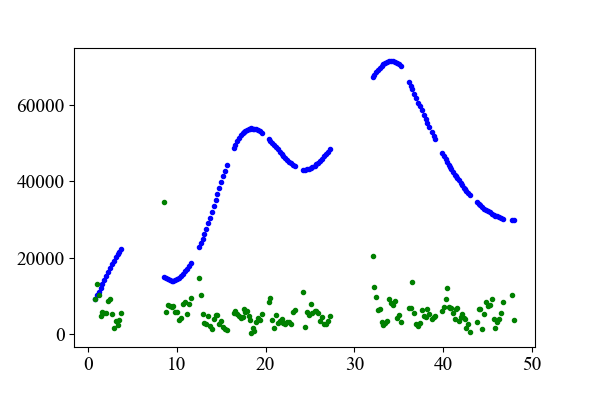

<IPython.core.display.Javascript object>


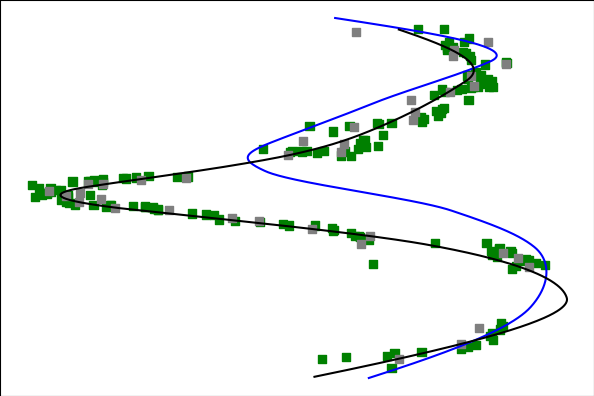

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [52]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt

print('Number of observations:', nobs)

plt.figure()
plt.plot(obs_times, d_aemn_bt, 'b.')
plt.plot(obs_times, d_obs_bt, 'g.')

plt.figure()
# plot all the ensembles
#for tn in range(0,nens):
    #plt.plot(ensTracks[tn][:,2], ensTracks[tn][:,3], 'b--')
    
# plot the AEMN track
aemn_x = list(aemnTrack[:,2]) 
aemn_y = list(aemnTrack[:,3])
aemn_t = forecast_periods
aemn_fine_t = np.linspace(0,max(forecast_periods),1000)
aemn_fine_x, aemn_fine_y, aemn__fine_t = storm_position_akima(aemn_x, aemn_y, aemn_t, aemn_fine_t)
plt.plot(aemn_fine_x, aemn_fine_y, 'b')


# plot the best track
bt_x = list(bestTrack[:,2]) 
bt_y = list(bestTrack[:,3])
bt_t = forecast_periods
bt_fine_t = np.linspace(0,max(forecast_periods),1000)
bt_fine_x, bt_fine_y, bt_fine_t = storm_position_akima(bt_x, bt_y, bt_t, bt_fine_t)
plt.plot(bt_fine_x, bt_fine_y, 'k')

# plot the observed positions
seen = np.array(seen)
plt.scatter(obs_positions[:,0], obs_positions[:,1], c = seen.flatten(), marker='s',cmap=cmap, norm=norm,)

# plot the observd (Calculated) track
'''
ksp_x = list(known_storm_pos[:,0]) 
ksp_y = list(known_storm_pos[:,1])
ksp_t = list(known_storm_pos[:,2])
ksp_fine_t = np.linspace(0,max(forecast_periods),1000)
ksp_fine_x, ksp_fine_y, ksp__fine_t = storm_position_akima(ksp_x, ksp_y, ksp_t, ksp_fine_t)
plt.plot(ksp_fine_x, ksp_fine_y, 'o')
'''
plt.scatter(known_storm_position[:,0], known_storm_position[:,1], c = 'tab:grey', marker='s')

plt.xlabel('X')
plt.ylabel('Y')
plt.show();
print(seen.flatten(),)
plt.gca().set_position([0, 0, 1, 1])


<IPython.core.display.Javascript object>


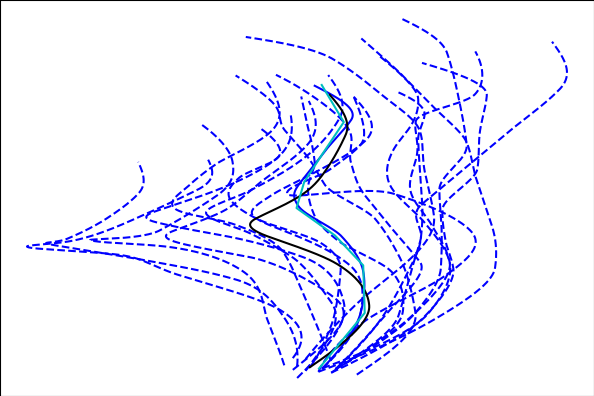

In [53]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt

# produce the mean ensemble for an example forecast and see if it matches with the corresponding AEMN track 
ens_wts0 = np.ones((nens, 1))
ens_wts0 = ens_wts0/ np.sum(ens_wts0)
mean0_track = mean_ensemble(ensTracks, ens_wts0)

    
plt.figure()
# plot all the ensembles
for tn in range(0,nens):
    ens_x = list(ensTracks[tn][:,2]) 
    ens_y = list(ensTracks[tn][:,3])
    ens_t = forecast_periods
    ens_fine_t = np.linspace(0,max(forecast_periods),1000)
    ens_fine_x, ens_fine_y, ens__fine_t = storm_position_akima(ens_x, ens_y, ens_t, ens_fine_t)
    plt.plot(ens_fine_x*1e-3, ens_fine_y*1e-3, 'b--')
    
# plot the AEMN track
aemn_x = list(aemnTrack[:,2]) 
aemn_y = list(aemnTrack[:,3])
aemn_t = forecast_periods
aemn_fine_t = np.linspace(0,max(forecast_periods),1000)
aemn_fine_x, aemn_fine_y, aemn__fine_t = storm_position_akima(aemn_x, aemn_y, aemn_t, aemn_fine_t)
plt.plot(aemn_fine_x*1e-3, aemn_fine_y*1e-3, 'b')


# plot the best track
bt_x = list(bestTrack[:,2]) 
bt_y = list(bestTrack[:,3])
bt_t = forecast_periods
bt_fine_t = np.linspace(0,max(forecast_periods),1000)
bt_fine_x, bt_fine_y, bt_fine_t = storm_position_akima(bt_x, bt_y, bt_t, bt_fine_t)
plt.plot(bt_fine_x*1e-3, bt_fine_y*1e-3, 'k')

# plot the Calculated mean track
plt.plot(mean0_track[:,2]*1e-3, mean0_track[:,3]*1e-3, 'c')

# plot the observed positions
#seen = np.array(seen)
#plt.scatter(obs_positions[:,0]*1e-3, obs_positions[:,1]*1e-3, c = seen.flatten(), marker='s')


# known_storm_position
#plt.scatter(known_storm_position[:,0]*1e-3, known_storm_position[:,1]*1e-3, c = 'tab:orange', marker='s')


plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.show();
plt.gca().set_position([0, 0, 1, 1])


<IPython.core.display.Javascript object>


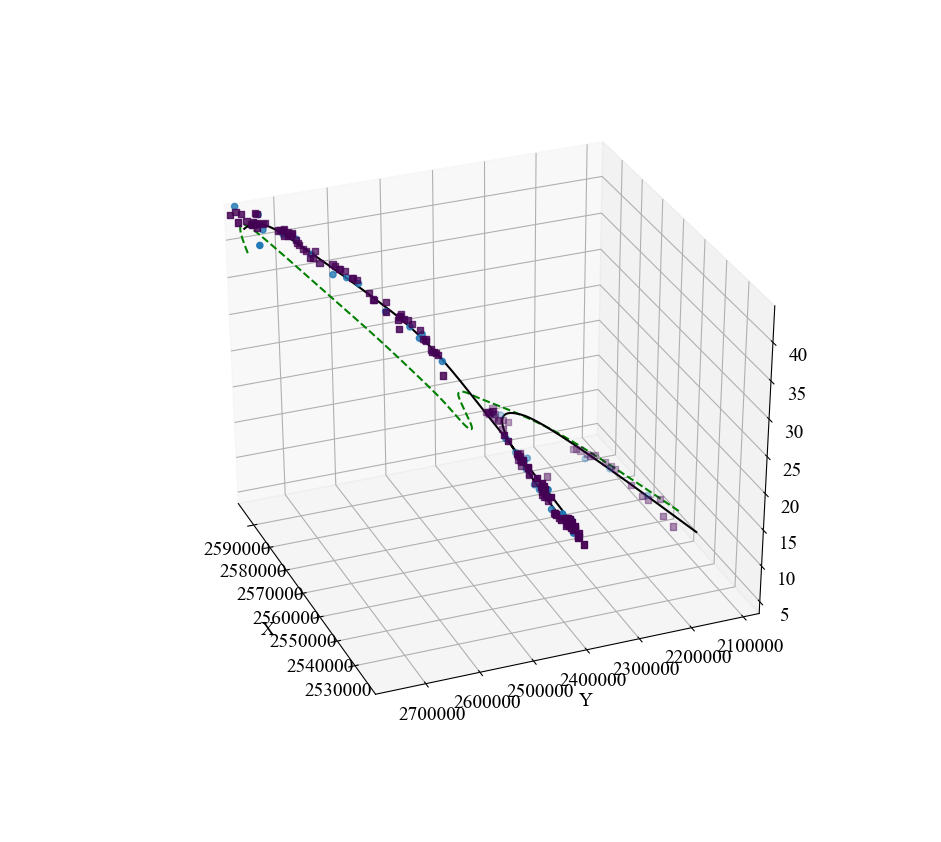

In [54]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# produce the mean ensemble for an example forecast and see if it matches with the corresponding AEMN track 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# plot all the ensembles
#for tn in range(0,nens):
    #ax.plot(ensTracks[tn][:,2], ensTracks[tn][:,3], forecast_periods,'b--')
    
# plot the AEMN track
aemn_x = list(aemnTrack[:,2]) 
aemn_y = list(aemnTrack[:,3])
aemn_t = forecast_periods
aemn_fine_t = np.linspace(0,max(forecast_periods),1000)
aemn_fine_x, aemn_fine_y, aemn__fine_t = storm_position_akima(aemn_x, aemn_y, aemn_t, aemn_fine_t)  
ax.plot(aemn_fine_x, aemn_fine_y, aemn_fine_t, 'g--')

# plot the best track
bt_x = list(bestTrack[:,2]) 
bt_y = list(bestTrack[:,3])
bt_t = forecast_periods
bt_fine_t = np.linspace(0,max(forecast_periods),1000)
bt_fine_x, bt_fine_y, bt_fine_t = storm_position_akima(bt_x, bt_y, bt_t, bt_fine_t)
ax.plot(bt_fine_x, bt_fine_y, bt_fine_t, 'k')

# plot the observed positions
seen = np.array(seen)
ax.scatter(obs_positions[:,0], obs_positions[:,1], obs_times, c = seen.flatten(), marker='s')

# plot the known storm positions
ax.scatter(known_storm_position[:,0], known_storm_position[:,1], known_storm_position[:,2])

plt.xlabel('X')
plt.ylabel('Y')
plt.show();

<IPython.core.display.Javascript object>


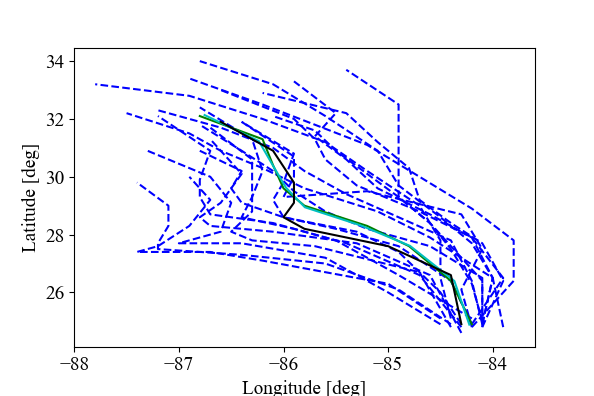

In [45]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt

# produce the mean ensemble for an example forecast and see if it matches with the corresponding AEMN track 
ens_wts0 = np.ones((nens, 1))
ens_wts0 = ens_wts0/ np.sum(ens_wts0)
mean0_track = mean_ensemble(ensTracks, ens_wts0)

    
plt.figure()
# plot all the ensembles
for tn in range(0,nens):
    lon, lat =  proj(ensTracks[tn][:,2], ensTracks[tn][:,3], inverse=True)
    plt.plot(lon, lat, 'b--')
    
# plot the AEMN track
lon, lat =  proj(aemnTrack[:,2], aemnTrack[:,3], inverse=True)
plt.plot(lon, lat,  'g')

# plot the Calculated mean track
lon, lat =  proj(mean0_track[:,2], mean0_track[:,3], inverse=True)
plt.plot(lon, lat, 'c')

# plot the best track
lon, lat =  proj(bestTrack[:,2], bestTrack[:,3], inverse=True)
plt.plot(lon, lat,  'k')

plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')
plt.show();

In [ ]:
lon

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


<IPython.core.display.Javascript object>


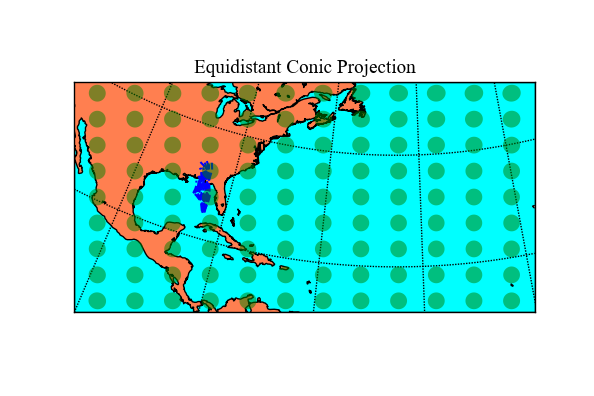

In [46]:
if(basin == 'Al'):
    # North Atlantic basin borders: lat: 0 deg to 50 deg, lon: 10W to 100W
    # Choose standard parallels: 16.67N and  33.33N, central lon: 45W, llcrnrlon=-100 , llcrnrlat=0, urcrnrlon=-10, urcrnrlat=50
    proj = Basemap(resolution='l',projection='eqdc',\
                lat_1=16.67,lat_2=33.33,lon_0=-45.0,
                llcrnrlon=-100 , llcrnrlat=0 , urcrnrlon=-10, urcrnrlat=50  )
plt.figure()

proj.drawcoastlines()
proj.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
proj.drawparallels(np.arange(-80.,81.,20.))
proj.drawmeridians(np.arange(-180.,181.,20.))
proj.drawmapboundary(fill_color='aqua')
ax = plt.gca()
for y in np.linspace(proj.ymax/20,19*proj.ymax/20,9):
    for x in np.linspace(proj.xmax/20,19*proj.xmax/20,12):
        lon, lat = proj(x,y,inverse=True)
        poly = proj.tissot(lon,lat,1.5,100,\
                        facecolor='green',zorder=10,alpha=0.5)
plt.title("Equidistant Conic Projection")

# plot all the ensembles
for tn in range(0,nens):
    plt.plot(ensTracks[tn][:,2], ensTracks[tn][:,3], 'b--')

In [ ]:
# Comparing Akima interpolation with B-spline interpolation

%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

bt_x = list(bestTrack[:,2]) # get best-track info for the kth dataset
bt_y = list(bestTrack[:,3])
bt_t = forecast_periods

#plot best track with AKima interpolation
bt_fine_t = np.linspace(0,max(forecast_periods),1000)
bt_fine_x, bt_fine_y, bt_fine_t = storm_position_akima(bt_x, bt_y, bt_t, bt_fine_t)
ax.plot(bt_fine_x, bt_fine_y, bt_fine_t, 'g')

# plot the best track using bspline interpolation
tck, u = interpolate.splprep([bt_x, bt_y, bt_t], s=0.001) 
u_fine = np.linspace(0,1,1000)
bt_fine_x, bt_fine_y, bt_fine_t = interpolate.splev(u_fine, tck)
ax.plot(bt_fine_x, bt_fine_y, bt_fine_t, 'b')

plt.xlabel('X')
plt.ylabel('Y')
plt.show();